## A Week 10 visualization problem. 

Load up the [Victoria PD Crime Report page](https://www.crimereports.com/agency/vicpdcanada) page. 

This page displays the crimes investigated by the Victoria Police Department over various time spans.  You can click on "Advanced Search" to set the crime types to display, and also the date ranges. 

If you click on "Show Details" you can download that page, it should give you a "CrimeReports.com Crime List.html" file and some other files in a subdirectory.  Notice that all the crime data is contained in the html file.  I have created a [simple application](scrape.CrimeReports.ipynb) that automates the process of gathering the data and storing it in a simple database. 

For this homework assignment we ask you to use data scraped from the Victoria PD Crime Report page and perform some (hopefully informative!) statistical analysis. 

The output for the data range from September 14th, 2015 until March 11th, 2016 is available in [this directory](dl.14.Sep.2015-11.Mar.2016.json.bz2) as a compressed json file.   This file gives a sampling of some analysis we could do.  At the end of the file will appear your homework assignment, to continue these visualizations. 


# Part 1

Let's pull the data from the json file. The data is stored on two lines, each one being a list of records.  One record is a dict-type object. 

In [1]:
import simplejson as json
from datetime import datetime, date

f=open("dl.14.Sep.2015-11.Mar.2016.json", "r")
bigDat=[]
## the data appears in two lines, this is because the 2nd line
## data does not contain "Identifier" tag, it also does not contain
## a specific time for the event.  You will also notice a few
## records in bigDat[0] do not contain GPS coordinates. 
bigDat.append( json.loads(f.readline()) )
bigDat.append( json.loads(f.readline()) )
f.close()
print("bigDat[0] sample: ",bigDat[0][0], "\n\n", "bigDat[1] sample: ", bigDat[1][0])


bigDat[0] sample:  {'Identifier': '15-47488', 'Address': '1700 Block CORONATION AVE', 'GPS': ['48.431633', '-123.33125'], 'Description': '', 'Crime Type': 'Other', 'Date/Time': '13-Oct-2015 11:24 PM'} 

 bigDat[1] sample:  {'Address': '1900 Block STORE ST', 'Date': '18-Sep-2015', 'Crime Type': 'Breaking & Entering', 'GPS': ['48.431153', '-123.369736']}


In [2]:
## now let's convert the text string "date" to proper dates, and gps coordinates to floats.
for i in range(2):
    for x in bigDat[i]:
        ## if i==0 we have a date/time field, and a gps field that needs conversion
        if 'GPS' in x: 
            x['GPS'][0] = float(x['GPS'][0])
            x['GPS'][1] = float(x['GPS'][1])
        ## if i==1 we have a date field and a geps field that needs conversion
        if i==0:
            x['Date/Time'] = datetime.strptime(x['Date/Time'], "%d-%b-%Y %H:%M %p") 
        if i==1:
            x['Date'] = datetime.strptime(x['Date'], "%d-%b-%Y").date()


## Part 2: basic analysis of the data. 

In [3]:
## returns the list of recorded crime types from the parsed list as argument
def recTypes(listRec):
    recT = set([])
    for R in listRec:
        recT.add(R['Crime Type'])
    recT = list(recT)
    return recT

## Let's break down the basic crime types. Take in a list of crimes, returns
## a dict (type, number).  So first lets create a set of all the crime types. 

def recCounts(listRec):
    recTyp = recTypes(listRec)
    counts = dict([(x,0) for x in recTyp])
    for R in listRec:
        counts[R['Crime Type']] += 1
    return counts

In [4]:
bigList = list(bigDat[0])
bigList.extend(bigDat[1])

In [5]:
breakD = recCounts(bigList)
print(breakD)
print("Total records: ", len(bigList))

{'Liquor': 724, 'Breaking & Entering': 329, 'Theft of Vehicle': 120, 'Drugs': 226, 'Disorder': 180, 'Assault with Deadly Weapon': 128, 'Arson': 18, 'Robbery': 59, 'Pedestrian Stop': 446, 'Traffic': 1614, 'Theft from Vehicle': 600, 'Property Crime': 582, 'Vehicle Stop': 260, 'Alarm': 106, 'Other': 1724, 'Community Policing': 2, 'Assault': 49, 'Theft': 1426, 'Weapons Offense': 61}
Total records:  8654


In [6]:
## Let's create a pie chart 
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib inline
%matplotlib nbagg

tot = len(bigList)
cTypes = [k for k,v in breakD.items()]
fractions = [100*v/tot for k,v in breakD.items()]

## re-arrange the order to make a more pleasant plot
sortme = [(cTypes[i], fractions[i]) for i in range(len(cTypes))]
import operator
sortme.sort(key=operator.itemgetter(1))
newlist = []
count=0
while len(sortme)>0:
    if count % 2 == 1: 
        newlist.append(sortme[0])
        sortme.pop(0)
    else:
        newlist.append(sortme[-1])
        sortme.pop()
    count+=1

fractions = [newlist[i][1] for i in range(len(newlist))]
cTypes = [newlist[i][0] for i in range(len(newlist))]

<IPython.core.display.Javascript object>


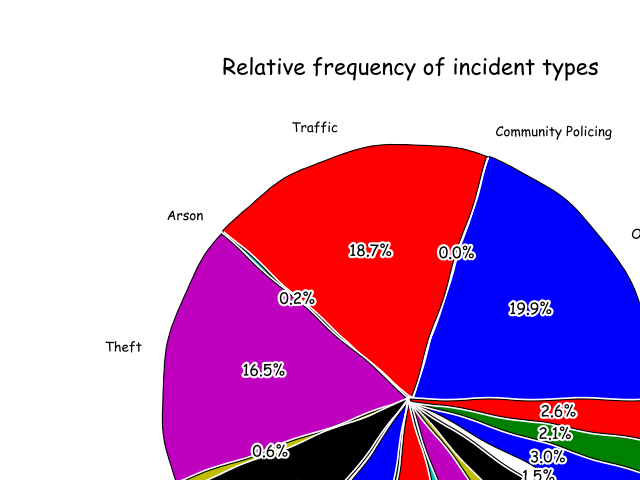

In [7]:
with plt.xkcd(): ## this enables the xkcd style.
    
    fig=plt.figure()
    fig.set_size_inches(10,10) 
    
    #pushOut = (0,0.1,0,0) ##
    
    ## explode is the push-out parameter.  labels are the text around the
    ## circumference.  autopct puts the percentage in the pie slices. 
    ## shadow adds a bit of depth to the image.
    plt.pie(fractions, labels=cTypes, autopct='%1.1f%%', shadow=False)
    ## shadow=True / False
    plt.title('Relative frequency of incident types', fontsize=20)
    


## Part 3: some more sophisticated data analysis


In [8]:
## Let's break the above data base up by the days of the week. Monday 0 through Sunday 6.
weekArr = [[],[],[],[],[],[],[]]
for x in bigList:
    ## check if has Date field or Date/Time field
    if 'Date/Time' in x:
        weekArr[x['Date/Time'].weekday()].append(x)
    else:
        weekArr[x['Date'].weekday()].append(x)
for x in weekArr:
    print(len(x))
    

1148
1232
1216
1238
1353
1291
1176


In [9]:
## oh, we should be careful.  How many mondays are in our date range, etc? 
from datetime import date
weekDays = [set(),set(),set(),set(),set(),set(),set()]
for x in bigList:
    if 'Date/Time' in x:
        weekDays[x['Date/Time'].weekday()].add(x['Date/Time'].date())
    else:
        weekDays[x['Date'].weekday()].add(x['Date'])

In [10]:
for i in range(7):
    print(i, len(weekDays[i]))

0 26
1 26
2 26
3 26
4 26
5 25
6 25


In [11]:
## So we can compute the average number of crimes per weekday
avgArr=[]
for i in range(7):
    avgArr.append(len(weekArr[i])/len(weekDays[i]))

In [12]:
weekNames=['Monday', 'Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
## Let's write out the weekdays by how bad the crime rates are.
sortme = [(i, avgArr[i]) for i in range(len(avgArr))]
sortme.sort(key=operator.itemgetter(1))
print(sortme)
print("The days of the week in order of ascending crime rates: ")
for x in sortme:
    print(weekNames[x[0]], " -> ", x[1])

[(0, 44.15384615384615), (2, 46.76923076923077), (6, 47.04), (1, 47.38461538461539), (3, 47.61538461538461), (5, 51.64), (4, 52.03846153846154)]
The days of the week in order of ascending crime rates: 
Monday  ->  44.15384615384615
Wednesday  ->  46.76923076923077
Sunday  ->  47.04
Tuesday  ->  47.38461538461539
Thursday  ->  47.61538461538461
Saturday  ->  51.64
Friday  ->  52.03846153846154


In [13]:
count = 0
for x in bigList:
    if 'GPS' not in x:
        count += 1
print(count, len(bigList))
## one in 40 records missing GPS coordinates. 
## we could write a routine to put those in, or just ignore these records for now.

208 8654


## Basic heat map 

In [14]:
print(recTypes(bigList))

['Liquor', 'Breaking & Entering', 'Assault with Deadly Weapon', 'Theft of Vehicle', 'Drugs', 'Community Policing', 'Theft from Vehicle', 'Arson', 'Pedestrian Stop', 'Vehicle Stop', 'Weapons Offense', 'Alarm', 'Other', 'Traffic', 'Disorder', 'Robbery', 'Assault', 'Theft', 'Property Crime']


In [23]:
## Heatmap, of Assault with a Deadly Weapon. 
import folium
from folium import plugins

import numpy as np

## data needs to be a list [x,y,z] [x,y] the gps coordinates and z the "heat"
## so let's run through the GPS coordinates, and build this list and decide on what
## the "heat" should be. 
data = []
for x in bigList:
    if ('GPS' in x) and (x['Crime Type']=="Assault with Deadly Weapon"):
        newpt = [x['GPS'][0], x['GPS'][1], 0.02 ]
        ## decide on "heat"
        data.append( newpt )
mapa = folium.Map([48.4323, -123.3720], tiles='Stamen Terrain', zoom_start=13)
mapa.add_children(plugins.HeatMap(data))
#mapa.create_map(path='awdw.heatmap.html')
mapa

In [26]:
## Heatmap, drugs on Fridays
data = []
for x in bigList:
    if ('GPS' in x) and (x['Crime Type']=="Drugs"):
        ## plot Drugs on Fridays...
        if (('Date/Time' in x) and (x['Date/Time'].weekday()==4)) or \
           (('Date' in x) and (x['Date'].weekday()==4)):
            newpt = [x['GPS'][0], x['GPS'][1], 0.1 ]
            data.append( newpt )
            
mapa = folium.Map([48.4323, -123.3720], tiles='OpenStreetMap', zoom_start=13)
mapa.add_children(plugins.HeatMap(data))
#mapa.create_map(path='awdw.heatmap.html')
mapa

In [35]:
# Let's make a stacked bar chart indicating crime types by weekday

ctypes = recTypes(bigList) ## string rep crime type names
arrCount = np.zeros( (len(ctypes), len(weekNames)) )
for x in bigList:
    if 'Date' in x:
        wN = x['Date'].weekday()
    elif 'Date/Time' in x:
        wN = x['Date/Time'].weekday()
    arrCount[next(k for k in range(len(ctypes)) if ctypes[k]==x['Crime Type']), wN]+=1
## arrCount[i] is the crime counts by weekday for ctypes[i]

## matrix of partial sums
psum = np.zeros( (len(ctypes), len(weekNames)) )
for j in range(len(weekNames)):
    for i in range(len(ctypes)):
        ## psum[i,j] = psum[i,j-1] + arrCount[i,j]
        if i==0: psum[i,j] = 0
        else: psum[i,j] = psum[i-1,j] + arrCount[i-1,j]

print(arrCount[0], arrCount[1])
print(psum[0], psum[1])

[ 11.   8.   6.  10.  12.   5.   7.] [ 12.   8.  15.  18.  24.  18.  11.]
[ 0.  0.  0.  0.  0.  0.  0.] [ 11.   8.   6.  10.  12.   5.   7.]


<IPython.core.display.Javascript object>


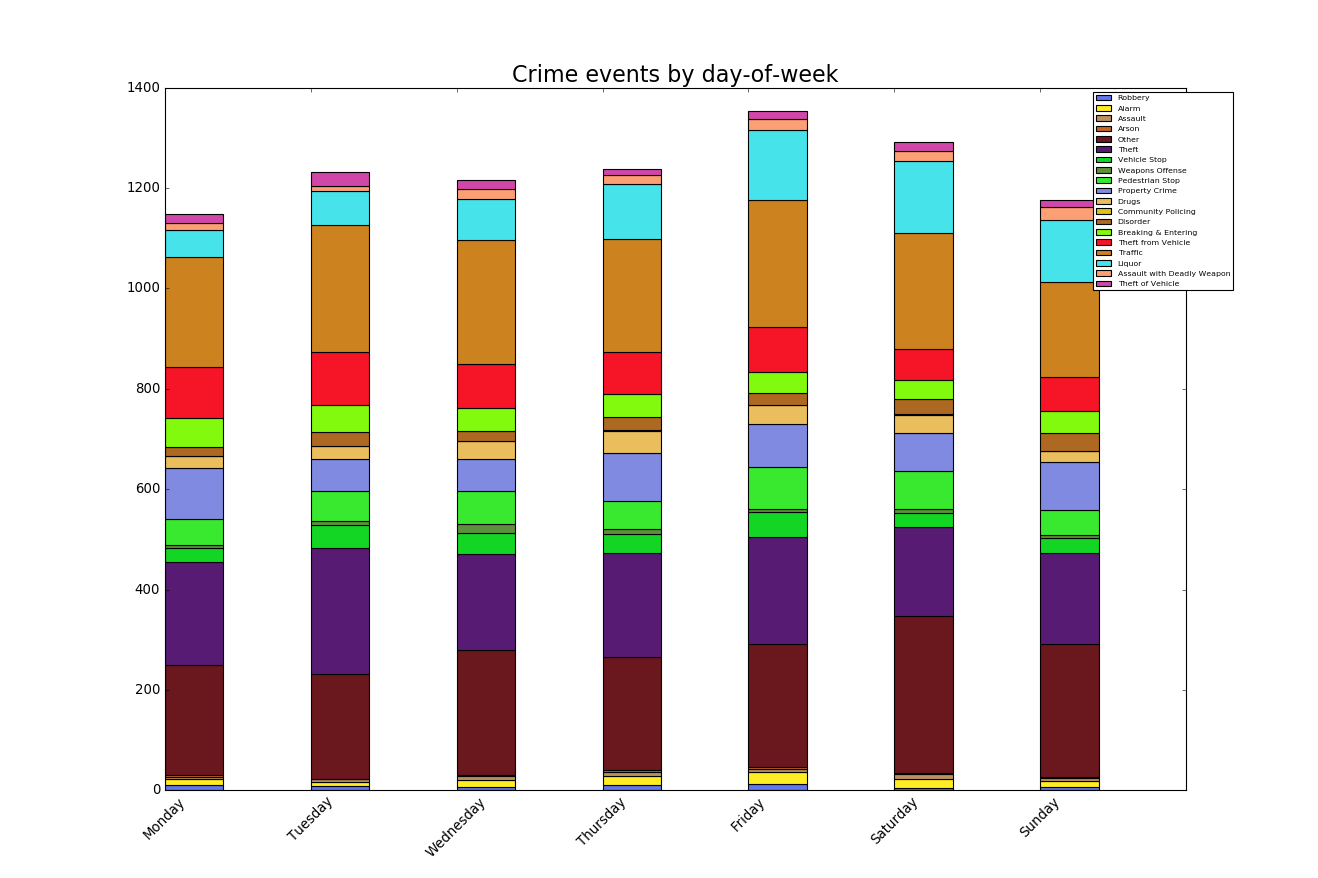

In [69]:
%matplotlib nbagg

colarr = [np.random.rand(3,1) for i in range(len(ctypes))]

import matplotlib.pyplot as plt
fig = plt.figure() ## get the figure-object for our plot.

width = 0.4
xc = list(range(len(weekNames)))
p = [] ## plot array

for i in range(len(ctypes)):
    if i==0:
        p.append( plt.bar(xc, arrCount[i].tolist(), width, color=colarr[i] ) )
    else:
        p.append( plt.bar(xc, arrCount[i].tolist(), width, color=colarr[i], bottom=psum[i]) )

ax1 = plt.subplot(111)
plt.xticks(xc, weekNames, rotation=45)
#ax1.set_xticklabels( xc, rotation=45 )
plt.title('Crime events by day-of-week', fontsize=20)

ax1.legend(p, ctypes, prop={'size':7}, bbox_to_anchor=(1.05,1.0))
        
plt.show()